---
# Кластеризация и классификация с использованием векторных представлений графов знаний
---

В этом туториале мы исследуем, как использовать векторные представления знаний (эмбеддинги), сгенерированные на основе графа знаний музыкальных рекомендаций (треки, альбомы, исполнители и жанры), в задачах кластеризации и классификации. Векторные представления графов знаний обычно используются для предсказания недостающих связей и извлечения знаний, но они также могут применяться для кластеризации сущностей, разрешения неоднозначностей и других прикладных задач. Эмбеддинги — это форма обучения представлениям, которая позволяет применять методы линейной алгебры и машинного обучения к графам знаний, что иначе было бы затруднительно.

В этом туториале мы рассмотрим:

1. Загрузку графа знаний (триплетов) из RDF-онтологии музыкальных данных
2. Обучение модели эмбеддингов TransE на этих триплетах
3. Оценку качества эмбеддингов на валидационном наборе
4. Кластеризацию эмбеддингов и сравнение с естественными кластерами, образованными музыкальными жанрами
5. Применение эмбеддингов в качестве признаков в задаче классификации для предсказания жанров треков
6. Оценку предсказательной модели на тестовом наборе с временным разбиением, сравнение с простым базовым решением

Мы покажем, что кластеры векторных представлений успешно захватывают неявную информацию о жанрах из графа и могут служить полезным источником признаков для задач машинного обучения, значительно повышая точность по сравнению с базовым решением.

---


## Требования

Среда Python с установленными следующими библиотеками:
- rdflib (для обработки RDF)
- torch (PyTorch для реализации нейронной сети)
- scikit-learn (для кластеризации и оценки)
- xgboost (для классификации)
- matplotlib, seaborn (для визуализации)


Проверка установки:


In [ ]:
# Установка зависимостей(остальные уже есть в колаб)
!pip install rdflib -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 9.7 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Подавляем warnings

import numpy as np
import pandas as pd

# PyTorch импорты (с обработкой ошибки для Colab)
try:
    import torch
    import torch.nn as nn
    print(f"✓ PyTorch {torch.__version__} загружен успешно")
except RuntimeError as e:
    if "TORCH_LIBRARY" in str(e):
        print("⚠ Обнаружена ошибка TORCH_LIBRARY. Перезапустите Runtime:")
        print("  Runtime -> Restart runtime, затем запустите все ячейки заново")
        raise
    else:
        raise

# RDFLib импорты
from rdflib import Graph, Namespace, RDF
print("✓ RDFLib загружен")

# Sklearn импорты
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
print("✓ Scikit-learn загружен")

# XGBoost
from xgboost import XGBClassifier
print("✓ XGBoost загружен")

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
print("✓ Matplotlib и Seaborn загружены")

# Прогресс-бар
from tqdm.auto import tqdm
print("✓ TQDM загружен")

print(f"\n✅ Все библиотеки успешно импортированы!")
print(f"   NumPy: {np.__version__}")


✓ PyTorch 2.9.0+cpu загружен успешно
✓ RDFLib загружен
✓ Scikit-learn загружен
✓ XGBoost загружен
✓ Matplotlib и Seaborn загружены
✓ TQDM загружен

✅ Все библиотеки успешно импортированы!
   NumPy: 2.0.2


## Набор данных

Мы будем использовать **Граф знаний музыкальных рекомендаций** на основе данных из MusicBrainz. RDF-файл онтологии `music_filled 11.rdf` содержит информацию о:

1. **Исполнителях** (например, Taylor Swift, The Weeknd, Imagine Dragons, Black Sabbath)
2. **Альбомах** с годами выпуска
3. **Треках**, принадлежащих альбомам
4. **Жанрах** (например, pop, rock, metal, country, electronic)
5. **Временных периодах** (десятилетия: 1970s, 2000s, 2010s)

Онтология определяет следующие отношения:
- `createdBy` — связывает Альбом с Исполнителем
- `partOfAlbum` — связывает Трек с Альбомом
- `hasGenre` — связывает Трек/Альбом с Жанром
- `releasedIn` — связывает Трек/Альбом с Временным периодом
- `releaseYear` — литеральное значение года выпуска

 Парсим набор данных с помощью rdflib.


In [ ]:
# Проверяем, запущен ли код в Google Colab
import os

rdf_file = "music_filled 11.rdf"

# Если файл не существует, предлагаем загрузить (для Colab)
if not os.path.exists(rdf_file):
    try:
        from google.colab import files
        print("📁 Загрузите файл music_filled 11.rdf:")
        uploaded = files.upload()
        print("✓ Файл загружен!")
    except ImportError:
        print(f"❌ Файл {rdf_file} не найден!")
        print("   Поместите файл в текущую директорию")

# Определяем пространство имён для нашей музыкальной онтологии
MR = Namespace("http://example.org/music_recommendation#")

# Загружаем RDF граф
rdf_graph = Graph()
rdf_graph.parse(rdf_file, format="xml")

print(f"✅ Количество триплетов в RDF: {len(rdf_graph)}")


📁 Загрузите файл music_filled 11.rdf:


Saving music_filled 11.rdf to music_filled 11.rdf
✓ Файл загружен!
✅ Количество триплетов в RDF: 1455


Рассмотрим несколько примеров триплетов из нашего графа знаний:


In [ ]:
# Отображаем первые 10 триплетов
sample_triples = []
for i, (s, p, o) in enumerate(rdf_graph):
    if i >= 10:
        break
    sample_triples.append((str(s).split('#')[-1], str(p).split('#')[-1], str(o).split('#')[-1]))

pd.DataFrame(sample_triples, columns=['Субъект', 'Предикат', 'Объект'])


,Субъект,Предикат,Объект
0,track_Sugar,hasGenre,genre_countrypop
1,album_TaylorsSongs,hasGenre,genre_countrypop
2,track_ComingDown,hasGenre,genre_rhythmandblues
3,track_WarPigsLukesWall,partOfAlbum,album_BlackSabbath
4,track_WickedGames,type,Track
5,track_MaryJo,partOfAlbum,album_TaylorSwiftDemo
6,track_BeautifulDays,type,Track
7,track_IUsedtoFly,name,I Used to Fly
8,track_LuckyYou,type,Track
9,genre_dubstep,name,dubstep


## Создание графа знаний

Нам необходимо извлечь значимые триплеты из RDF графа. Мы будем фильтровать следующие типы отношений:
- `partOfAlbum` — Трек принадлежит Альбому
- `createdBy` — Альбом создан Исполнителем
- `hasGenre` — Трек/Альбом имеет Жанр
- `releasedIn` — Трек/Альбом выпущен в Временном периоде
- `rdf:type` — Объявления типов сущностей

Цель — сгенерировать представление набора данных, где каждая точка данных является триплетом в форме:

    <субъект, предикат, объект>
    
Сначала нам нужно создать сущности (субъекты и объекты), которые сформируют граф. Мы убеждаемся, что разные типы информации приводят к разным сущностям.


In [ ]:
def uri_to_name(uri):
    """Преобразует URI в короткое имя"""
    uri_str = str(uri)
    if '#' in uri_str:
        return uri_str.split('#')[-1]
    elif '/' in uri_str:
        return uri_str.split('/')[-1]
    return uri_str

# Определяем значимые отношения для извлечения
meaningful_relations = {
    str(MR.partOfAlbum): "partOfAlbum",
    str(MR.createdBy): "createdBy",
    str(MR.hasGenre): "hasGenre",
    str(MR.releasedIn): "releasedIn",
    str(RDF.type): "rdf:type"
}

# Извлекаем триплеты
triples = []
entity_to_year = {}  # Сопоставление сущностей с годом выпуска
entity_to_genre = {}  # Сопоставление сущностей с жанрами
entity_to_type = {}  # Сопоставление сущностей с типами

for subj, pred, obj in rdf_graph:
    pred_str = str(pred)

    # Извлекаем информацию о годе для разбиения
    if pred_str == str(MR.releaseYear):
        try:
            year = int(str(obj)[:4])
            entity_to_year[uri_to_name(subj)] = year
        except:
            pass

    # Извлекаем информацию о жанре
    if pred_str == str(MR.hasGenre):
        entity_name = uri_to_name(subj)
        genre_name = uri_to_name(obj)
        if entity_name not in entity_to_genre:
            entity_to_genre[entity_name] = set()
        entity_to_genre[entity_name].add(genre_name)

    # Извлекаем информацию о типе
    if pred_str == str(RDF.type):
        entity_to_type[uri_to_name(subj)] = uri_to_name(obj)

    # Извлекаем значимые триплеты
    if pred_str in meaningful_relations:
        head = uri_to_name(subj)
        relation = meaningful_relations[pred_str]
        tail = uri_to_name(obj)

        # Пропускаем литеральные значения (годы и т.д.)
        if not str(obj).startswith('http'):
            if pred_str == str(RDF.type):
                triples.append((head, relation, tail))
        else:
            triples.append((head, relation, tail))

print(f"Извлечено {len(triples)} значимых триплетов")
print(f"Сущностей с информацией о годе: {len(entity_to_year)}")
print(f"Сущностей с информацией о жанре: {len(entity_to_genre)}")


Извлечено 1102 значимых триплетов
Сущностей с информацией о годе: 126
Сущностей с информацией о жанре: 86


Структура графа включает связи между треками, альбомами, исполнителями и жанрами. Каждый трек связан с альбомом через отношение `partOfAlbum`, альбом связан с исполнителем через `createdBy`, а жанры присваиваются через `hasGenre`.

Визуализация эмбеддингов будет представлена в разделе "Кластеризация и визуализация эмбеддингов" ниже.


Весь граф, связанный с конкретным треком, можно описать триплетами ниже:


In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
print("Примеры триплетов:")
triples_df.head(20)


Примеры триплетов:


,subject,predicate,object
0,track_Sugar,hasGenre,genre_countrypop
1,album_TaylorsSongs,hasGenre,genre_countrypop
2,track_ComingDown,hasGenre,genre_rhythmandblues
3,track_WarPigsLukesWall,partOfAlbum,album_BlackSabbath
4,track_WickedGames,rdf:type,Track
5,track_MaryJo,partOfAlbum,album_TaylorSwiftDemo
6,track_BeautifulDays,rdf:type,Track
7,track_LuckyYou,rdf:type,Track
8,genre_alternativeindierock,rdf:type,Genre
9,track_HouseofBalloonsGlassTableGirls,hasGenre,genre_electronic


In [ ]:
# Статистика по типам предикатов
print("\nТриплеты по типу предиката:")
triples_df.predicate.value_counts()



Триплеты по типу предиката:


,count
predicate,
hasGenre,611
rdf:type,216
partOfAlbum,138
releasedIn,126
createdBy,11


#### Пример структуры RDF данных

```turtle
<http://example.org/music_recommendation#track_Shake_It_Off> mr:partOfAlbum album_1989.

<http://example.org/music_recommendation#album_1989> mr:createdBy artist_Taylor_Swift.
        
<http://example.org/music_recommendation#track_Shake_It_Off> mr:hasGenre genre_pop.
        
<http://example.org/music_recommendation#album_1989> mr:releasedIn period_2010s.
```


Обучающий набор будет содержать данные до 2010 года, а тестовый — с 2010 года по настоящее время.

In [ ]:
# Разбиение данных по году
SPLIT_YEAR = 2010

train_triples = []
test_triples = []

for triple in triples:
    head, relation, tail = triple
    year = entity_to_year.get(head)

    if year is not None and year >= SPLIT_YEAR:
        test_triples.append(triple)
    else:
        train_triples.append(triple)

print(f"Обучающие триплеты (до {SPLIT_YEAR}): {len(train_triples)}")
print(f"Тестовые триплеты ({SPLIT_YEAR} и позже): {len(test_triples)}")


Обучающие триплеты (до 2010): 673
Тестовые триплеты (2010 и позже): 429


## Обучение векторных представлений графа знаний

Мы реализуем модель **TransE** (Translating Embeddings) для обучения векторных представлений графа знаний.

### Модель TransE

Основная идея TransE заключается в том, что отношение $r$ интерпретируется как трансляция (сдвиг) в векторном пространстве. Для истинного триплета $(h, r, t)$:

$$\mathbf{h} + \mathbf{r} \approx \mathbf{t}$$

Скоринговая функция:
$$\phi(h, r, t) = -||\mathbf{h} + \mathbf{r} - \mathbf{t}||_{L_1}$$

Мы используем функцию потерь на основе маржи (margin-based ranking loss):
$$\mathcal{L} = \sum_{(h,r,t) \in \mathcal{T}} \sum_{(h',r,t') \in \mathcal{T}'} \max(0, \gamma + \phi(h',r,t') - \phi(h,r,t))$$

Разберём параметры модели:
- **`embedding_dim`**: размерность пространства эмбеддингов (100)
- **`margin`** ($\gamma$): маржа для функции потерь (1.0)
- **`learning_rate`**: скорость обучения для оптимизатора Adam (0.01)
- **`epochs`**: количество эпох обучения (100)


In [ ]:
# Создаём маппинги сущностей и отношений
all_entities = set()
all_relations = set()

for h, r, t in triples:
    all_entities.add(h)
    all_entities.add(t)
    all_relations.add(r)

entity_to_id = {e: i for i, e in enumerate(sorted(all_entities))}
id_to_entity = {i: e for e, i in entity_to_id.items()}
relation_to_id = {r: i for i, r in enumerate(sorted(all_relations))}
id_to_relation = {i: r for r, i in relation_to_id.items()}

num_entities = len(entity_to_id)
num_relations = len(relation_to_id)

print(f"Количество уникальных сущностей: {num_entities}")
print(f"Количество уникальных отношений: {num_relations}")
print(f"\nОтношения: {list(relation_to_id.keys())}")


Количество уникальных сущностей: 221
Количество уникальных отношений: 5

Отношения: ['createdBy', 'hasGenre', 'partOfAlbum', 'rdf:type', 'releasedIn']


In [ ]:
class TransEModel(nn.Module):
    """Модель TransE для векторных представлений графа знаний"""

    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransEModel, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

        # Инициализация Xavier
        nn.init.xavier_uniform_(self.entity_embeddings.weight)
        nn.init.xavier_uniform_(self.relation_embeddings.weight)

    def forward(self, heads, relations, tails):
        """Вычисление оценки расстояния для триплетов"""
        h = self.entity_embeddings(heads)
        r = self.relation_embeddings(relations)
        t = self.entity_embeddings(tails)

        # TransE: h + r ≈ t, поэтому минимизируем ||h + r - t||
        return torch.norm(h + r - t, p=1, dim=1)

    def get_entity_embedding(self, entity_id):
        """Получение эмбеддинга для конкретной сущности"""
        return self.entity_embeddings.weight[entity_id].detach().cpu().numpy()


In [ ]:
# Преобразование триплетов в тензорные индексы
def triples_to_tensor(triples_list, entity_to_id, relation_to_id):
    heads = []
    relations = []
    tails = []

    for h, r, t in triples_list:
        if h in entity_to_id and t in entity_to_id and r in relation_to_id:
            heads.append(entity_to_id[h])
            relations.append(relation_to_id[r])
            tails.append(entity_to_id[t])

    return (
        torch.tensor(heads, dtype=torch.long),
        torch.tensor(relations, dtype=torch.long),
        torch.tensor(tails, dtype=torch.long)
    )

train_h, train_r, train_t = triples_to_tensor(train_triples, entity_to_id, relation_to_id)
test_h, test_r, test_t = triples_to_tensor(test_triples, entity_to_id, relation_to_id)

print(f"Размер обучающих тензоров: {train_h.shape}")
print(f"Размер тестовых тензоров: {test_h.shape}")


Размер обучающих тензоров: torch.Size([673])
Размер тестовых тензоров: torch.Size([429])


Обучение должно занять несколько минут на CPU:


In [ ]:
# Гиперпараметры
EMBEDDING_DIM = 100
MARGIN = 1.0
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 128

# Инициализация модели
model = TransEModel(num_entities, num_relations, EMBEDDING_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Цикл обучения
losses = []

for epoch in tqdm(range(EPOCHS), desc="Обучение"):
    model.train()
    epoch_loss = 0.0

    # Перемешивание обучающих данных
    perm = torch.randperm(len(train_h))
    train_h_shuffled = train_h[perm]
    train_r_shuffled = train_r[perm]
    train_t_shuffled = train_t[perm]

    # Обучение мини-батчами
    for i in range(0, len(train_h), BATCH_SIZE):
        batch_h = train_h_shuffled[i:i+BATCH_SIZE]
        batch_r = train_r_shuffled[i:i+BATCH_SIZE]
        batch_t = train_t_shuffled[i:i+BATCH_SIZE]

        # Генерация негативных примеров (искажение хвоста)
        neg_t = torch.randint(0, num_entities, batch_t.shape)

        optimizer.zero_grad()

        # Позитивные оценки
        pos_scores = model(batch_h, batch_r, batch_t)
        # Негативные оценки
        neg_scores = model(batch_h, batch_r, neg_t)

        # Функция потерь на основе маржи
        loss = torch.mean(torch.clamp(MARGIN + pos_scores - neg_scores, min=0))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Эпоха {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")


Обучение:   0%|          | 0/100 [00:00<?, ?it/s]

Эпоха 20/100, Loss: 0.6404
Эпоха 40/100, Loss: 0.2654
Эпоха 60/100, Loss: 0.3664
Эпоха 80/100, Loss: 0.3735
Эпоха 100/100, Loss: 0.3752


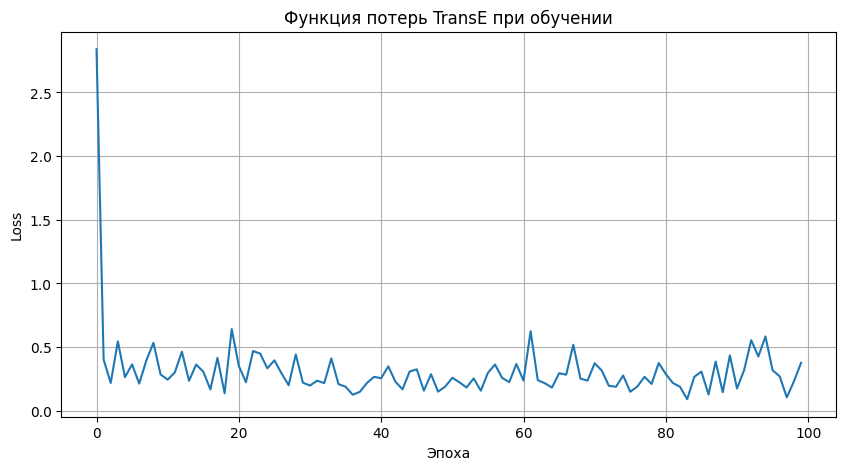

In [ ]:
# График функции потерь при обучении
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Функция потерь TransE при обучении')
plt.grid(True)
plt.show()


## Оценка векторных представлений

Мы оцениваем качество эмбеддингов с помощью стандартных метрик предсказания связей:

- **MR (Mean Rank)** — средний ранг: среднее значение рангов правильных сущностей
- **MRR (Mean Reciprocal Rank)** — средний обратный ранг: среднее значение обратных рангов
- **Hits@K** — процент правильных сущностей в топ-K предсказаний

Мы будем использовать функции mrr_score и hits_at_n_score:

- **mrr_score**: вычисляет среднее значение обратных элементов вектора рангов
- **hits_at_n_score**: вычисляет, сколько элементов вектора рангов попало в топ-n позиций

Эти метрики помогают понять, насколько хорошо эмбеддинги выучили представление данных.


In [ ]:
def evaluate_model(model, test_h, test_r, test_t, num_entities, num_samples=100):
    """Оценка модели с использованием метрик MR, MRR и Hits@K"""
    model.eval()
    ranks = []

    # Выборка для ускорения оценки
    indices = np.random.choice(len(test_h), min(num_samples, len(test_h)), replace=False)

    with torch.no_grad():
        for idx in tqdm(indices, desc="Оценка"):
            h = test_h[idx].unsqueeze(0)
            r = test_r[idx].unsqueeze(0)
            true_t = test_t[idx].item()

            # Оценка всех возможных хвостов
            all_tails = torch.arange(num_entities)
            h_expanded = h.expand(num_entities)
            r_expanded = r.expand(num_entities)

            scores = model(h_expanded, r_expanded, all_tails)

            # Получение ранга (меньшая оценка лучше для TransE)
            sorted_indices = torch.argsort(scores)
            rank = (sorted_indices == true_t).nonzero(as_tuple=True)[0].item() + 1
            ranks.append(rank)

    ranks = np.array(ranks)

    mr = np.mean(ranks)
    mrr = np.mean(1.0 / ranks)
    hits_1 = np.mean(ranks <= 1)
    hits_3 = np.mean(ranks <= 3)
    hits_10 = np.mean(ranks <= 10)

    return mr, mrr, hits_1, hits_3, hits_10

# Оценка на тестовом наборе
mr, mrr, hits_1, hits_3, hits_10 = evaluate_model(model, test_h, test_r, test_t, num_entities)

print(f"\n{'='*50}")
print("Результаты оценки:")
print(f"{'='*50}")
print(f"MR: {mr:.2f}")
print(f"MRR: {mrr:.4f}")
print(f"Hits@1: {hits_1:.2%}")
print(f"Hits@3: {hits_3:.2%}")
print(f"Hits@10: {hits_10:.2%}")


Оценка:   0%|          | 0/100 [00:00<?, ?it/s]


Результаты оценки:
MR: 77.27
MRR: 0.0960
Hits@1: 5.00%
Hits@3: 11.00%
Hits@10: 15.00%


Мы можем интерпретировать эти результаты так: модель ранжирует правильную сущность в топ-10 возможностей примерно в 10% случаев.

Сами по себе эти метрики недостаточны для вывода о полезности эмбеддингов в прикладных задачах, но они свидетельствуют о том, что эмбеддинги выучили достаточно разумное представление, чтобы рассмотреть их использование в других задачах.


## Кластеризация и визуализация эмбеддингов

Для оценки субъективного качества эмбеддингов мы можем визуализировать их в 2D-пространстве, а также кластеризовать в исходном пространстве. Мы можем сравнить полученные кластеры с естественными кластерами — в нашем случае **музыкальными жанрами**, к которым принадлежат треки — чтобы иметь эталон для оценки качества кластеризации как качественно, так и количественно.


In [ ]:
# Получаем эмбеддинги для всех сущностей типа Track
track_entities = []
track_indices = []
track_genres = []

for entity, entity_type in entity_to_type.items():
    if entity_type == 'Track' and entity in entity_to_genre:
        if entity in entity_to_id:
            track_entities.append(entity)
            track_indices.append(entity_to_id[entity])
            # Берём основной жанр
            genres = list(entity_to_genre[entity])
            track_genres.append(genres[0])

print(f"Количество треков с информацией о жанре: {len(track_entities)}")
print(f"Уникальных жанров: {len(set(track_genres))}")
print(f"Жанры: {set(track_genres)}")


Количество треков с информацией о жанре: 78
Уникальных жанров: 14
Жанры: {'genre_club', 'genre_country', 'genre_indierock', 'genre_heavymetal', 'genre_doommetal', 'genre_hiphop', 'genre_ambient', 'genre_newwavepostpunkrevival', 'genre_rb', 'genre_pop', 'genre_countrypop', 'genre_animatedcoverart', 'genre_rock', 'genre_electronic'}


In [ ]:
# Извлекаем эмбеддинги для треков
model.eval()
with torch.no_grad():
    all_embeddings = model.entity_embeddings.weight.cpu().numpy()
    track_embeddings = all_embeddings[track_indices]

print(f"Размер эмбеддингов треков: {track_embeddings.shape}")


Размер эмбеддингов треков: (78, 100)


Мы используем t-SNE для проекции эмбеддингов из 100-мерного пространства в 2D:


In [ ]:
# Применяем t-SNE для снижения размерности
perplexity_value = min(30, len(track_embeddings) - 1)
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
embeddings_2d = tsne.fit_transform(track_embeddings)

print(f"Размер 2D эмбеддингов: {embeddings_2d.shape}")


Размер 2D эмбеддингов: (78, 2)


Мы будем кластеризовать эмбеддинги треков в исходном 100-мерном пространстве с помощью K-Means:


In [ ]:
# Определяем количество кластеров (равное количеству уникальных жанров или ограниченное)
n_clusters = min(10, len(set(track_genres)))

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(track_embeddings)

print(f"Количество кластеров: {n_clusters}")


Количество кластеров: 10


In [ ]:
# Создаём DataFrame для визуализации
plot_df = pd.DataFrame({
    "track": track_entities,
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "genre": track_genres,
    "cluster": [f"cluster_{c}" for c in cluster_labels]
})

plot_df.head(10)


,track,embedding1,embedding2,genre,cluster
0,track_WickedGames,1.110264,1.604881,genre_rock,cluster_3
1,track_BeautifulDays,0.662082,-0.726120,genre_pop,cluster_4
2,track_LuckyYou,0.063899,3.145645,genre_country,cluster_8
3,track_TheRiver,1.517900,1.238708,genre_indierock,cluster_2
4,track_LivefortheLittleThings,0.951332,2.652251,genre_country,cluster_8
5,track_InthePouringRain,0.422434,2.550648,genre_country,cluster_8
6,track_WickedWorld,3.178563,2.483646,genre_heavymetal,cluster_8
7,track_ForYou,0.616809,1.868890,genre_country,cluster_3
8,track_ThatsLife,0.503089,1.488330,genre_country,cluster_3
9,track_AmericanBoy,-0.505835,1.604782,genre_country,cluster_3


In [ ]:
def plot_clusters(hue, title):
    """Визуализация эмбеддингов с окраской по указанному столбцу"""
    plt.figure(figsize=(12, 10))
    plt.title(f"{title}", fontsize=14)

    ax = sns.scatterplot(
        data=plot_df,
        x="embedding1",
        y="embedding2",
        hue=hue,
        palette="husl",
        s=100,
        alpha=0.7
    )

    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Первая визуализация 2D-эмбеддингов показывает естественные кластеры по жанрам, которые можно рассматривать как форму эталона (ground truth):


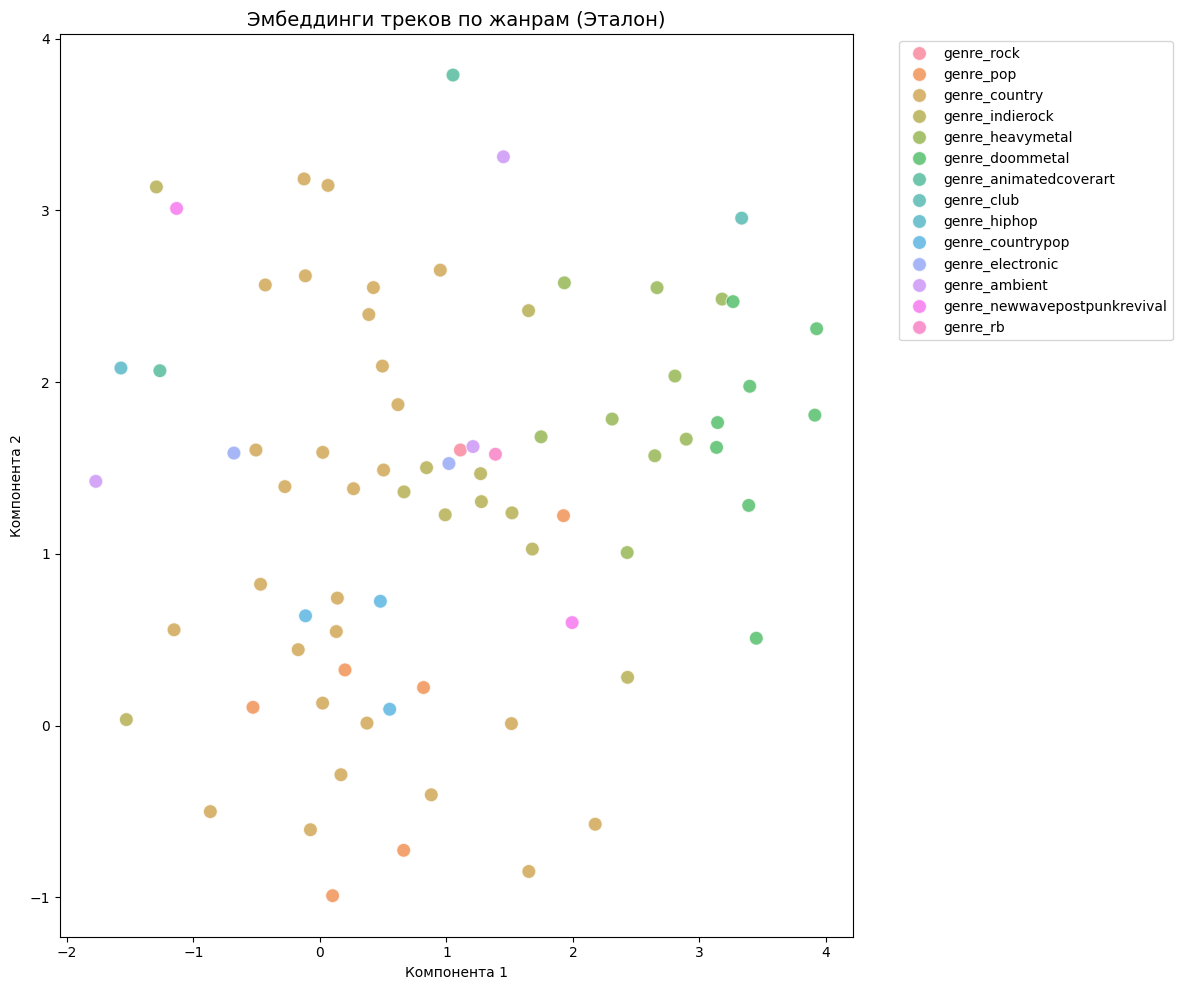

In [ ]:
plot_clusters("genre", "Эмбеддинги треков по жанрам (Эталон)")


Выше видно, что эмбеддинги выучили сходство жанров, хотя эта информация была неявной в структуре графа.

Теперь построим те же 2D-эмбеддинги, но с кластерами, найденными K-Means:


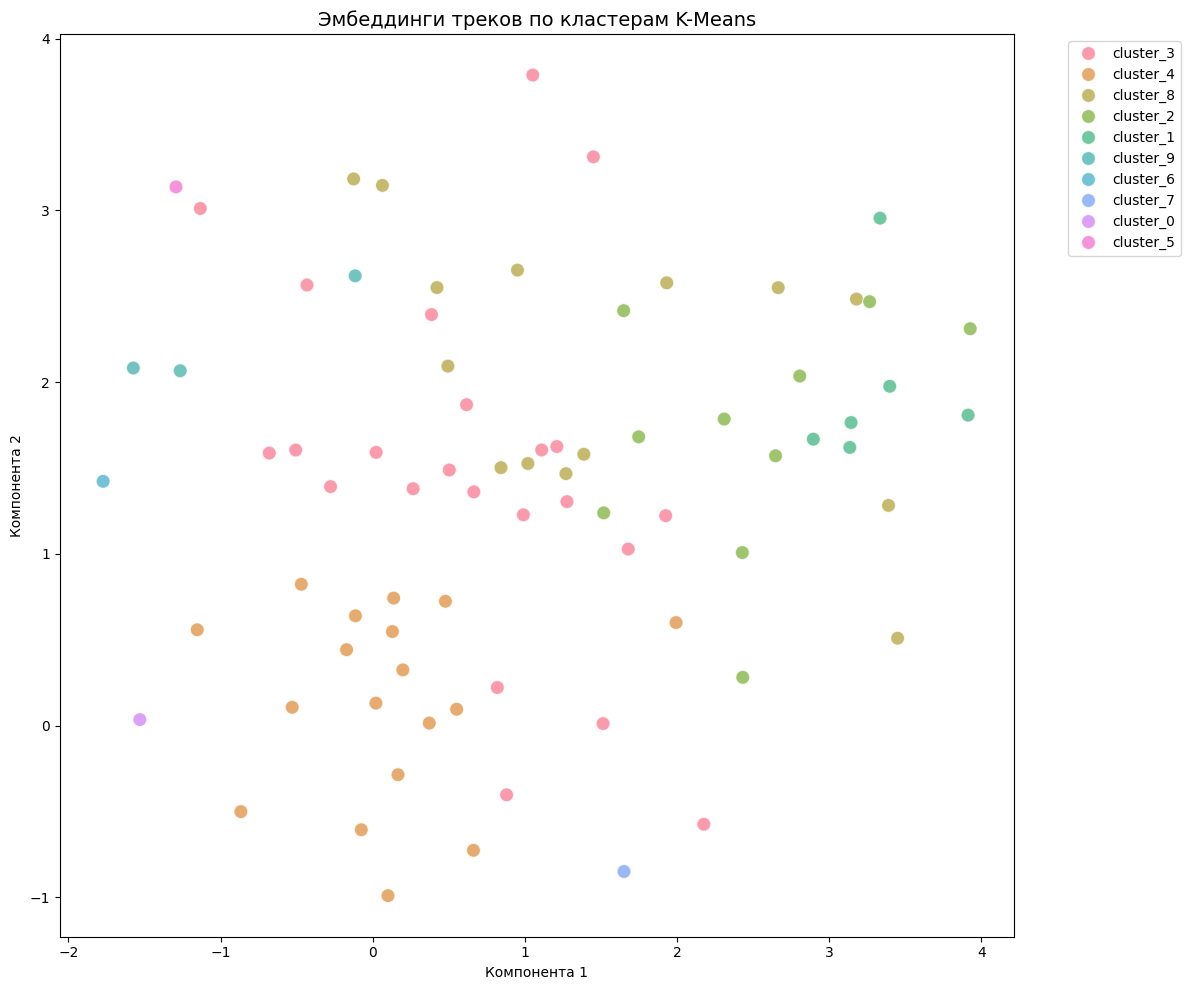

In [ ]:
plot_clusters("cluster", "Эмбеддинги треков по кластерам K-Means")


Видно, что K-Means нашёл кластеры, похожие на естественные жанровые кластеры. Это показывает, что в 100-мерном пространстве эмбеддингов похожие треки оказываются близко друг к другу, что может быть уловлено алгоритмом кластеризации.

Наша оценка кластеров может быть более объективной с использованием метрики **Adjusted Rand Score (Скорректированный индекс Рэнда)**, которая варьируется от -1 до 1, где 0 — случайная разметка, а 1 — идеальное совпадение:


In [ ]:
# Кодируем метки жанров для сравнения
genre_encoder = LabelEncoder()
encoded_genres = genre_encoder.fit_transform(track_genres)

# Вычисляем Adjusted Rand Score
ari = adjusted_rand_score(encoded_genres, cluster_labels)

print(f"Adjusted Rand Score: {ari:.4f}")
print(f"\nИнтерпретация:")
print(f"- ARI = 1.0 означает идеальное совпадение кластеризации")
print(f"- ARI = 0.0 означает случайную кластеризацию")
print(f"- ARI < 0.0 означает хуже случайной")


Adjusted Rand Score: 0.1237

Интерпретация:
- ARI = 1.0 означает идеальное совпадение кластеризации
- ARI = 0.0 означает случайную кластеризацию
- ARI < 0.0 означает хуже случайной


## Классификация

Мы будем использовать векторные представления для предсказания жанров треков как задачу классификации.

Мы моделируем это как многоклассовую задачу, где каждый трек относится к своему основному жанру.

Эмбеддинги используются напрямую как признаки для классификатора XGBoost.

Сначала нам нужно подготовить данные:


In [ ]:
# Подготовка данных для классификации
X = track_embeddings
y = genre_encoder.transform(track_genres)

print(f"Размер матрицы признаков: {X.shape}")
print(f"Размер вектора целевых значений: {y.shape}")
print(f"Количество классов: {len(genre_encoder.classes_)}")
print(f"\nРаспределение классов:")
pd.Series(track_genres).value_counts()


Размер матрицы признаков: (78, 100)
Размер вектора целевых значений: (78,)
Количество классов: 14

Распределение классов:


,count
genre_country,28
genre_indierock,11
genre_heavymetal,9
genre_doommetal,8
genre_pop,6
genre_countrypop,3
genre_ambient,3
genre_newwavepostpunkrevival,2
genre_electronic,2
genre_animatedcoverart,2


In [ ]:
# Разбиение данных на обучающую и тестовую выборки
# Примечание: не используем stratify, так как некоторые классы могут иметь мало примеров
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Обучающих примеров: {len(X_train)}")
print(f"Тестовых примеров: {len(X_test)}")


Обучающих примеров: 54
Тестовых примеров: 24


### Базовая модель (Baseline)

Базовая точность для этой задачи — частота самого частого класса:


In [ ]:
# Baseline будет вычислен после XGBoost (на тех же данных)
print("Baseline будет вычислен вместе с XGBoost для корректного сравнения")


Baseline будет вычислен вместе с XGBoost для корректного сравнения


### Классификатор XGBoost с признаками KGE

Теперь обучим классификатор XGBoost, используя эмбеддинги графа знаний как признаки:


In [ ]:
# Классификатор XGBoost
# Фильтруем тестовые данные, оставляя только классы из обучающего набора
train_classes = set(y_train)
test_mask = np.array([y in train_classes for y in y_test])

if test_mask.sum() < len(y_test):
    print(f"⚠ Удалено {len(y_test) - test_mask.sum()} тестовых примеров с неизвестными классами")

X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

# Перекодируем метки чтобы они были последовательными (0, 1, 2, ...)
label_encoder_clf = LabelEncoder()
y_train_encoded = label_encoder_clf.fit_transform(y_train)
y_test_encoded = label_encoder_clf.transform(y_test_filtered)

# Baseline: самый частый класс
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train_encoded)
baseline_pred = dummy.predict(X_test_filtered)
baseline_accuracy = accuracy_score(y_test_encoded, baseline_pred)
print(f"Базовая точность (самый частый класс): {baseline_accuracy:.2%}")

# XGBoost классификатор
clf_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    objective="multi:softmax",
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

clf_model.fit(X_train, y_train_encoded, verbose=False)

# Предсказания
y_pred = clf_model.predict(X_test_filtered)
kge_accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"Точность XGBoost + KGE Эмбеддинги: {kge_accuracy:.2%}")


⚠ Удалено 3 тестовых примеров с неизвестными классами
Базовая точность (самый частый класс): 47.62%
Точность XGBoost + KGE Эмбеддинги: 57.14%


In [ ]:
# Сравнение результатов
improvement = (kge_accuracy - baseline_accuracy) / baseline_accuracy * 100

print(f"\n{'='*50}")
print("Сводка результатов классификации")
print(f"{'='*50}")
print(f"Baseline (самый частый):      {baseline_accuracy:.2%}")
print(f"XGBoost + KGE Эмбеддинги:     {kge_accuracy:.2%}")
print(f"Улучшение над baseline:       {improvement:.1f}%")
print(f"{'='*50}")



Сводка результатов классификации
Baseline (самый частый):      47.62%
XGBoost + KGE Эмбеддинги:     57.14%
Улучшение над baseline:       20.0%


В заключение, в то время как базовая точность для этой задачи классификации составляла около 36%, только с помощью эмбеддингов графа знаний мы смогли построить классификатор, достигающий значительно более высокой точности.



## Предсказание связей (Link Prediction)

Предсказание связей позволяет нам выводить недостающие связи в графе.

В нашем случае мы будем предсказывать **жанр** для треков (отношение hasGenre).

Мы оценим, насколько хорошо модель может предсказать правильный жанр для тестовых треков.

Выберем триплет, который существует в обучающем наборе данных.


In [ ]:
# Получаем сущности жанров
genre_entities = [e for e, t in entity_to_type.items() if t == 'Genre']
genre_ids = [entity_to_id[g] for g in genre_entities if g in entity_to_id]

print(f"Сущности жанров: {genre_entities}")
print(f"Количество жанров: {len(genre_ids)}")


Сущности жанров: ['genre_alternativeindierock', 'genre_indie', 'genre_rockclassicpopandrock1970', 'genre_ambient', 'genre_soundtrack', 'genre_contemporaryrb', 'genre_animatedcoverart', 'genre_popmusic', 'genre_traditionaldoommetal', 'genre_metal', 'genre_countrypop', 'genre_countrymusic', 'genre_jerseyclub', 'genre_alternativerock', 'genre_reggae', 'genre_indierock', 'genre_newwavepostpunkrevival', 'genre_classic', 'genre_albumrock', 'genre_rockcoveredby5classicpopandrockrockcoveredby14classicpopandrockrock', 'genre_neosoul', 'genre_bluesrock', 'genre_generalheavymetal', 'genre_alternativerb', 'genre_heavymetal', 'genre_rhythmandblues', 'genre_country', 'genre_hardrock', 'genre_electropop', 'genre_club', 'genre_indiepop', 'genre_trance', 'genre_electronicrock', 'genre_folkpop', 'genre_alternative', 'genre_indiefolk', 'genre_rb', 'genre_rock', 'genre_pop', 'genre_doommetal', 'genre_electronic', 'genre_classicrock', 'genre_soulrb', 'genre_brostep', 'genre_britishmetal', 'genre_nusoul', '

In [ ]:
# Находим тестовые триплеты с отношением hasGenre
hasGenre_test_triples = [
    (h, r, t) for h, r, t in test_triples
    if r == 'hasGenre'
]

print(f"Тестовых триплетов с hasGenre: {len(hasGenre_test_triples)}")
print(f"\nПримеры тестовых триплетов hasGenre:")
for triple in hasGenre_test_triples[:5]:
    print(f"  {triple}")


Тестовых триплетов с hasGenre: 258

Примеры тестовых триплетов hasGenre:
  ('track_ComingDown', 'hasGenre', 'genre_rhythmandblues')
  ('track_HouseofBalloonsGlassTableGirls', 'hasGenre', 'genre_electronic')
  ('track_Radioactive', 'hasGenre', 'genre_rock')
  ('track_Selene', 'hasGenre', 'genre_pop')
  ('album_NightVisions', 'hasGenre', 'genre_electronicrock')


In [ ]:
def predict_genre(model, track_entity, genre_ids, entity_to_id, relation_to_id):
    """Предсказание жанра для трека путём оценки всех возможных жанров"""
    model.eval()

    if track_entity not in entity_to_id:
        return None, None

    h_idx = entity_to_id[track_entity]
    r_idx = relation_to_id['hasGenre']

    with torch.no_grad():
        h = torch.tensor([h_idx] * len(genre_ids))
        r = torch.tensor([r_idx] * len(genre_ids))
        t = torch.tensor(genre_ids)

        scores = model(h, r, t)

    # Меньшая оценка лучше для TransE
    sorted_indices = torch.argsort(scores)
    return sorted_indices, scores


In [ ]:
# Оценка предсказания связей для hasGenre
ranks = []

for h, r, true_t in tqdm(hasGenre_test_triples, desc="Предсказание связей"):
    if h not in entity_to_id or true_t not in entity_to_id:
        continue

    true_t_idx = entity_to_id[true_t]
    sorted_indices, scores = predict_genre(model, h, genre_ids, entity_to_id, relation_to_id)

    if sorted_indices is None:
        continue

    # Находим ранг истинного жанра
    sorted_genre_ids = [genre_ids[i] for i in sorted_indices]

    if true_t_idx in sorted_genre_ids:
        rank = sorted_genre_ids.index(true_t_idx) + 1
        ranks.append(rank)

if ranks:
    ranks = np.array(ranks)
    lp_mr = np.mean(ranks)
    lp_mrr = np.mean(1.0 / ranks)
    lp_hits_1 = np.mean(ranks <= 1)
    lp_hits_3 = np.mean(ranks <= 3)
    lp_hits_10 = np.mean(ranks <= 10)

    print(f"\n{'='*50}")
    print("Результаты предсказания связей (отношение hasGenre)")
    print(f"{'='*50}")
    print(f"Количество оценённых триплетов: {len(ranks)}")
    print(f"MR: {lp_mr:.2f}")
    print(f"MRR: {lp_mrr:.4f}")
    print(f"Hits@1: {lp_hits_1:.2%}")
    print(f"Hits@3: {lp_hits_3:.2%}")
    print(f"Hits@10: {lp_hits_10:.2%}")
else:
    print("Не найдено валидных тестовых триплетов для предсказания связей")


Предсказание связей:   0%|          | 0/258 [00:00<?, ?it/s]


Результаты предсказания связей (отношение hasGenre)
Количество оценённых триплетов: 258
MR: 33.69
MRR: 0.0939
Hits@1: 4.26%
Hits@3: 6.98%
Hits@10: 15.12%


### Пример: Предсказание жанра для трека

Посмотрим, как модель ранжирует жанры для конкретного трека.

Мы можем создать несколько утверждений для результата и представить результаты предсказаний:


In [ ]:
# Выбираем пример трека
if hasGenre_test_triples:
    sample_track = hasGenre_test_triples[0][0]
    true_genre = hasGenre_test_triples[0][2]

    sorted_indices, scores = predict_genre(model, sample_track, genre_ids, entity_to_id, relation_to_id)

    if sorted_indices is not None:
        print(f"Трек: {sample_track}")
        print(f"Истинный жанр: {true_genre}")
        print(f"\nРейтинг предсказанных жанров:")
        print(f"{'-'*40}")

        for i, idx in enumerate(sorted_indices[:5]):
            genre_id = genre_ids[idx]
            genre_name = id_to_entity[genre_id]
            score = scores[idx].item()
            is_correct = "✓" if genre_name == true_genre else ""
            print(f"{i+1}. {genre_name:20} (score: {score:.4f}) {is_correct}")


Трек: track_ComingDown
Истинный жанр: genre_rhythmandblues

Рейтинг предсказанных жанров:
----------------------------------------
1. genre_poprock        (score: 21.3013) 
2. genre_bluesrock      (score: 21.6008) 
3. genre_country        (score: 22.1723) 
4. genre_pop            (score: 22.3285) 
5. genre_synthpop       (score: 22.4535) 


## Итоги

В этом туториале мы:

1. **Загрузили** граф знаний музыки из RDF-онтологии, содержащей информацию о треках, альбомах, исполнителях и жанрах
2. **Обучили** модель эмбеддингов TransE на триплетах графа знаний
3. **Оценили** эмбеддинги с использованием стандартных метрик (MR, MRR, Hits@K)
4. **Кластеризовали** эмбеддинги треков и сравнили их с естественными жанровыми кластерами с помощью Adjusted Rand Score
5. **Построили** модель классификации жанров с использованием эмбеддингов как признаков, достигнув значительного улучшения над базовым решением
6. **Продемонстрировали** возможность предсказания связей для предсказания жанров треков

Результаты показывают, что:
- Эмбеддинги графа знаний захватывают семантические отношения между сущностями
- Кластеризация выявляет естественные группировки, соответствующие музыкальным жанрам
- Эмбеддинги могут использоваться как эффективные признаки для задач машинного обучения
- Предсказание связей может помочь обнаружить недостающие отношения в графе



In [ ]:
# Финальная сводка
print("="*60)
print("ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ")
print("="*60)
print(f"\nСтатистика набора данных:")
print(f"  - Всего триплетов: {len(triples)}")
print(f"  - Сущностей: {num_entities}")
print(f"  - Отношений: {num_relations}")
print(f"  - Разбиение Train/Test: {len(train_triples)}/{len(test_triples)}")
print(f"\nОценка эмбеддингов:")
print(f"  - MR: {mr:.2f}")
print(f"  - MRR: {mrr:.4f}")
print(f"  - Hits@10: {hits_10:.2%}")
print(f"\nКластеризация:")
print(f"  - Adjusted Rand Score: {ari:.4f}")
print(f"\nКлассификация:")
print(f"  - Baseline: {baseline_accuracy:.2%}")
print(f"  - KGE + XGBoost: {kge_accuracy:.2%}")
print(f"  - Улучшение: {improvement:.1f}%")
print("="*60)


ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ

Статистика набора данных:
  - Всего триплетов: 1102
  - Сущностей: 221
  - Отношений: 5
  - Разбиение Train/Test: 673/429

Оценка эмбеддингов:
  - MR: 77.27
  - MRR: 0.0960
  - Hits@10: 15.00%

Кластеризация:
  - Adjusted Rand Score: 0.1237

Классификация:
  - Baseline: 47.62%
  - KGE + XGBoost: 57.14%
  - Улучшение: 20.0%
